In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from textblob import TextBlob
import nltk
from nltk.corpus import stopwords
import re
from tqdm import tqdm



from crypto_chatter.graph import *

import networkx as nx

data_source = 'twitter'
index_name = 'blockchain-interoperability-attacks'

In [2]:
graph = CryptoTwitterUserGraph(index_name)

loaded graph edges in 1 seconds
loaded cached graph data in 102 seconds
constructed complete user graph in 111 seconds


In [3]:
G = graph.G

In [4]:
df = graph.data

In [5]:
len(df)

16625047

In [6]:
df.columns

Index(['created_at', 'extended_tweet.full_text', 'favorite_count', 'full_text',
       'geo', 'geo.coordinates', 'geo.type', 'id', 'quote_count',
       'quoted_status.created_at', 'quoted_status.extended_tweet.full_text',
       'quoted_status.favorite_count', 'quoted_status.full_text',
       'quoted_status.geo', 'quoted_status.id', 'quoted_status.quote_count',
       'quoted_status.reply_count', 'quoted_status.retweet_count',
       'quoted_status.text', 'quoted_status.truncated',
       'quoted_status.user.created_at', 'quoted_status.user.followers_count',
       'quoted_status.user.friends_count', 'quoted_status.user.geo_enabled',
       'quoted_status.user.id', 'quoted_status.user.location', 'reply_count',
       'retweet_count', 'text', 'truncated',
       'truncatedquoted_status.truncated', 'user.created_at',
       'user.followers_count', 'user.friends_count', 'user.geo_enabled',
       'user.id', 'user.location', 'quoted_status.geo.coordinates',
       'quoted_status.geo.type

In [26]:



def clean_text(text):
    stop_words = set(stopwords.words('english'))
    custom_stopwords = set(['amp', 'rt', 'via', '...', '...', '’', '—', '“', '”', '‘', '’', '...', '``', "''", '️', '...'])
    text = text.lower()
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'[@#]', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    words = text.split()
    filtered_words = [word for word in words if word not in stop_words and word not in custom_stopwords]
    cleaned_text = ' '.join(filtered_words)
    if(cleaned_text == None):
        cleaned_text = ''
    return cleaned_text


def get_sentiment(text):
    text = clean_text(text)
    analysis = TextBlob(text)
    if analysis.sentiment.polarity > 0:
        return 'Positive'
    elif analysis.sentiment.polarity < 0:
        return 'Negative'
    else:
        return 'Neutral'



In [29]:
nltk.download('stopwords')

df['full_text'] = df['full_text'].fillna('')

tqdm.pandas(desc="Applying sentiment analysis")
sentiments = df['full_text'].progress_apply(get_sentiment)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mridul/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Applying sentiment analysis: 100%|██████████████████████████████████████████████████| 16625047/16625047 [39:23<00:00, 7033.18it/s]


In [30]:
sentiments[0:100]

0      Neutral
1      Neutral
2      Neutral
3     Positive
4     Negative
        ...   
95     Neutral
96    Positive
97    Positive
98     Neutral
99    Positive
Name: full_text, Length: 100, dtype: object

In [31]:
df['full_text.sentiment'] = sentiments.apply(lambda x: 1 if x == 'Positive' else (2 if x == 'Negative' else 0))

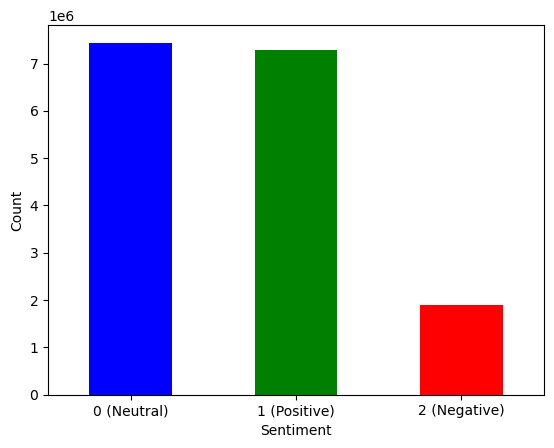

In [37]:
import matplotlib.pyplot as plt

sentiment_counts = df['full_text.sentiment'].value_counts()

sentiment_counts.plot(kind='bar', color=['blue', 'green', 'red'])

plt.xlabel('Sentiment')
plt.xticks([0, 1, 2], ['0 (Neutral)', '1 (Positive)', '2 (Negative)'], rotation=0)
plt.ylabel('Count')
# plt.title('Sentiment Distribution')

plt.show()


In [38]:
filtered_df = df[['full_text', 'favorite_count', 'reply_count', 'retweet_count', 'quote_count', 'full_text.sentiment']].dropna()

In [39]:
len(filtered_df)

16625047

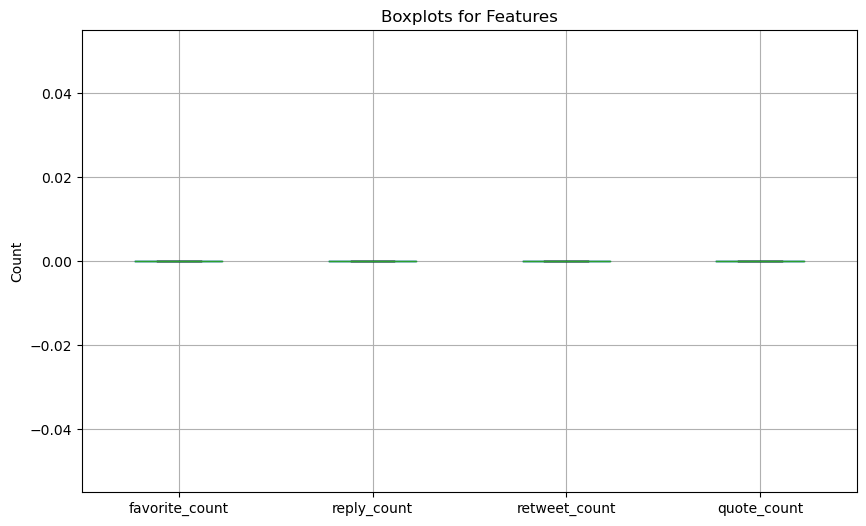

In [41]:
import matplotlib.pyplot as plt

features = ['favorite_count', 'reply_count', 'retweet_count', 'quote_count']

plt.figure(figsize=(10, 6))
filtered_df[features].boxplot(showfliers=False)
plt.title('Boxplots for Features')
plt.ylabel('Count')
plt.show()


In [43]:
filtered_df['favorite_count']

0          0
1          0
2          0
3          0
4          0
        ... 
25042     32
25043      0
25044    552
25045      0
25046      0
Name: favorite_count, Length: 16625047, dtype: int64

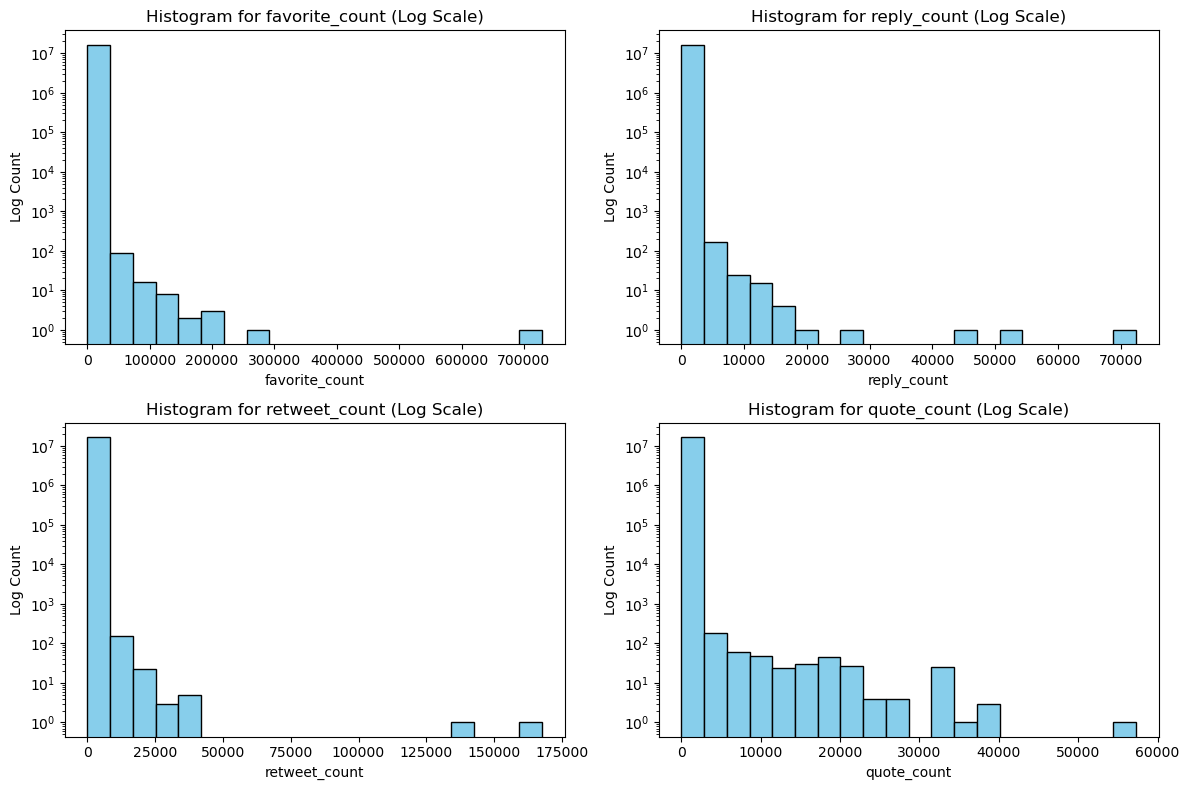

In [47]:
# Extract features
features = ['favorite_count', 'reply_count', 'retweet_count', 'quote_count']

# Create histograms for each feature in log scale
plt.figure(figsize=(12, 8))

for i, feature in enumerate(features, 1):
    plt.subplot(2, 2, i)
    plt.hist(filtered_df[feature], bins=20, color='skyblue', edgecolor='black', log=True)
    plt.title(f'Histogram for {feature} (Log Scale)')
    plt.xlabel(feature)
    plt.ylabel('Log Count')

plt.tight_layout()

plt.savefig("figures/features_stat.pdf", format="pdf", bbox_inches='tight', dpi=500)

plt.show()

In [53]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler

X = filtered_df[['favorite_count', 'reply_count', 'retweet_count', 'quote_count']]
y = filtered_df['full_text.sentiment']

# Split the data into training, validation, and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Create a Random Forest model
rf_model = RandomForestClassifier(random_state=42)

# Train the model on the training set
rf_model.fit(X_train_scaled, y_train)

# Make predictions on the validation set
y_val_pred = rf_model.predict(X_val_scaled)

# Evaluate the model on the validation set
accuracy_val = accuracy_score(y_val, y_val_pred)
print(f'Validation Accuracy: {accuracy_val}')

# Make predictions on the test set
y_test_pred = rf_model.predict(X_test_scaled)

# Evaluate the model on the test set
accuracy_test = accuracy_score(y_test, y_test_pred)
print(f'Test Accuracy: {accuracy_test}')

# Display classification report for the test set
print('Classification Report for Test Set:')
print(classification_report(y_test, y_test_pred))


Validation Accuracy: 0.45609095032114194
Test Accuracy: 0.45523944183838205
Classification Report for Test Set:
              precision    recall  f1-score   support

           0       0.45      0.96      0.62   1114189
           1       0.50      0.06      0.11   1093557
           2       0.21      0.00      0.01    286012

    accuracy                           0.46   2493758
   macro avg       0.39      0.34      0.24   2493758
weighted avg       0.44      0.46      0.32   2493758



In [55]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler

filtered_df = df[['favorite_count', 'reply_count', 'retweet_count', 'quote_count', 'full_text.sentiment']].dropna()

# Extract features and target
X = filtered_df[['favorite_count', 'reply_count', 'retweet_count', 'quote_count']]
y = filtered_df['full_text.sentiment']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Create a Random Forest model
rf_model = RandomForestClassifier(random_state=42)

# Define hyperparameter grid for tuning
param_grid = {
    'n_estimators': [50, 100, 200, 500],
}

# Perform grid search with k-fold cross-validation
grid_search = GridSearchCV(rf_model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

# Get the best model from grid search
best_rf_model = grid_search.best_estimator_

# Print the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)


# Print information about the best model
print("\nBest Model:")
print(best_rf_model)


Best Hyperparameters: {'n_estimators': 500}

Best Model:
RandomForestClassifier(n_estimators=500, random_state=42)


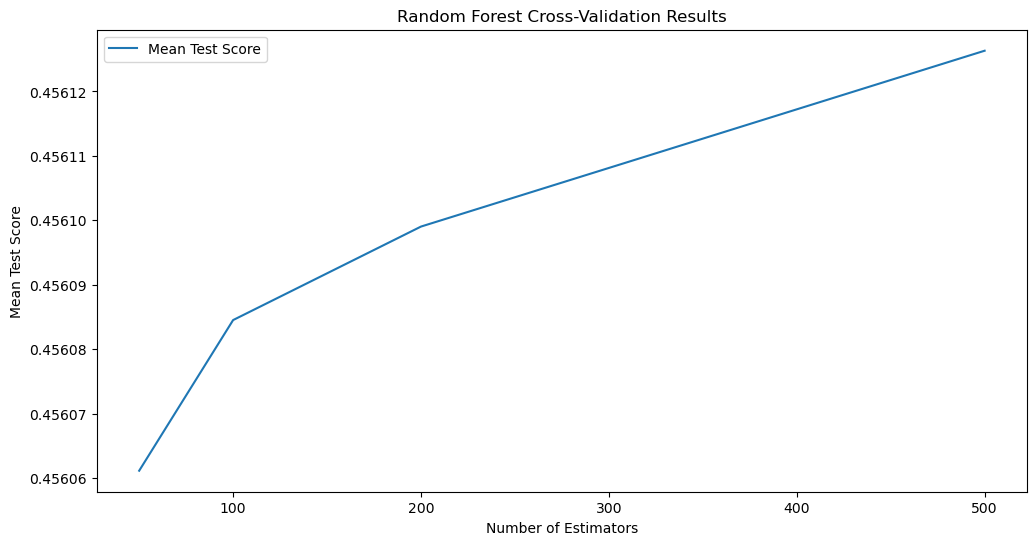

Test Accuracy: 0.4557162234098544
Classification Report for Test Set:
              precision    recall  f1-score   support

           0       0.45      0.96      0.62   1487317
           1       0.50      0.06      0.11   1457084
           2       0.21      0.00      0.01    380609

    accuracy                           0.46   3325010
   macro avg       0.39      0.34      0.24   3325010
weighted avg       0.44      0.46      0.32   3325010



In [56]:

# Plot the cross-validation results
cv_results = pd.DataFrame(grid_search.cv_results_)
plt.figure(figsize=(12, 6))
plt.plot(cv_results['param_n_estimators'], cv_results['mean_test_score'], label='Mean Test Score')
plt.xlabel('Number of Estimators')
plt.ylabel('Mean Test Score')
plt.title('Random Forest Cross-Validation Results')
plt.legend()
plt.show()

# Standardize the test set features
X_test_scaled = scaler.transform(X_test)

# Make predictions on the test set using the best model
y_test_pred = best_rf_model.predict(X_test_scaled)

# Evaluate the model on the test set
accuracy_test = accuracy_score(y_test, y_test_pred)
print(f'Test Accuracy: {accuracy_test}')

# Display classification report for the test set
print('Classification Report for Test Set:')
print(classification_report(y_test, y_test_pred))
